# Code for Normalizing Flows based on the Tabak-Turner paper

$$
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\DeclareMathOperator{\tr}{tr}
\DeclareMathOperator{\adj}{adj}
\DeclareMathOperator\erf{erf}
$$

The main difference between this program and Sahith's implementation of the Tabak Turner program is that in this program, the transport map is determined by a linear combination of the radial basis map instead of a composition. Here we need to make two major change.

1. The Jacobian $J_{n+1}$ is computed by $J_{n+1} = J_n$ if $r=0$ and $J_{n+1} = \beta(f(r)I + f'(r)/r(x^0-\tilde x^{n+1})(x^0-\tilde x^{n+1})^T)$. Where $x^0$ is the particle's position at time $0$ and $\tilde x^{n+1}$ is the center of the radial basis function randomly chosen. This is calculated by differentiating the function
$$
x^{n+1} = x^n + \beta f(r)(x^0-\tilde x^{n+1})
$$

2. We calculate the gradient of the log likelihood as follows:
The gradient of the log likelihood can be written as

$$
\frac{\partial}{\partial \beta} \log (\det J_{n+1}) \mid_{\beta = 0}
$$

We can write the expression as
\begin{align*}
 \frac{\partial}{\partial \beta} \log (\det J_{n+1}) &= \frac{\partial/\partial \beta (\det J_{n+1})\mid_{\beta = 0}}{\det J_{n+1}\mid_{\beta = 0}}   \\
 &= \frac{\tr(\adj (J_{n}) (\partial/\partial\beta) J_{n+1}\mid_{\beta = 0})}{\det J_{n}} \qquad \textrm{by Jacobi's formula}
\end{align*}
Here, $\adj(J_n)$ is the adjugate matrix of $J_n$. If $J_n$ is invertible, $\adj(J_n) = J_n^{-1}\det J_n$ and the expression can be written as
$$
\frac{\partial}{\partial \beta} \log(\det J_{n+1}) = \tr\left(J_n^{-1} \frac{\partial }{\partial \beta} J_{n+1}\mid_{\beta = 0}\right)
$$
$\partial/\partial \beta J_{n+1}$ is the entry-wise differentiation with respect to $\beta$. In particular, if $x_i^0 = \tilde x^{n+1}$, we know $\partial/\partial \beta J_{n+1}\mid_{\beta = 0} = 0$ is the all zero matrix. If otherwise,


$$
\frac{\partial}{\partial \beta} J_{n+1}\mid_{\beta = 0} = f(r_{n+1})I + \frac{f'(r_{n+1})}{r_{n+1}}(x_i^0 - \tilde x^{n+1})(x_i^0 - \tilde x^{n+1})^T
$$
In this case, therefore,
$$
\frac{\partial}{\partial \beta} \log(\det J_{n+1}) \mid_{\beta = 0} = \tr\left(J_n^{-1}\left(fI + \frac{f'}{r}(x_i^0 - \tilde x^{n+1})(x_i^0 - \tilde x^{n+1})^T\right)\right)
$$
Let $\mu$ be the pdf of independent normal distribution. We know
\begin{align*}
    \frac{\partial}{\partial \beta} \log \mu (T(x))\mid_{\beta = 0} &= \frac{\partial}{\partial \beta} \left(-\frac n 2\log(2\pi) - \frac 1 2 \norm{T(x)}^2\right)\mid_{\beta = 0} \\
    &= - T(x)\mid_{\beta = 0} \cdot \frac{\partial}{\partial \beta}T(x)\mid_{\beta = 0} \\
    &= - x_i^n \cdot \frac{\partial}{\partial \beta} x_i^{n+1}\mid_{\beta = 0} \\
    &= - x_i^n \cdot f(\norm{x_i^0 - \tilde x^{n+1}})(x_i^0 - \tilde x^{n+1})
\end{align*}
Therefore, if $x_i^0 \neq \tilde x^{n+1}$, the gradient of the log likelihood is determined by
\begin{align*}
    \frac{\partial}{\partial \beta} L &= \frac{\partial}{\partial \beta} \log(J_{n+1}) + \log \mu(T(x))\mid_{\beta = 0} \\
    &= \tr\left(J_n^{-1}\left(fI + \frac{f'}{r}(x_i^0 - \tilde x^{n+1})(x_i^0 - \tilde x^{n+1})^T\right)\right)-x_i^n \cdot f(\norm{x_i^n - \tilde x^{n+1}})(x_i^0 - \tilde x^{n+1})
\end{align*}
If $x_i^0 = \tilde x^{n+1}$, the gradient of the log likelihood is simply $0$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigvals
from scipy.linalg import eigh
from scipy.special import erf, gamma
from matplotlib.colors import LogNorm
import pandas as pd

def estimate_forward_KL(X, flow, log_rho_exact):

    # compute log-density under the exact model
    log_ex = log_rho_exact(X)

    # compute log-density under the flow estimate
    log_est = flow.log_prob(X)

    # Monte Carlo KL
    kl_mc = np.mean(log_ex - log_est)
    return kl_mc


class NormalizingFlow:
    """
    This code is an adaptation of Sahith's code implementing the Tabak Turner algorithm. In this code we use the method of linearly combining the elementary radial basis map instead of composing them. In this version of the implementation, I did not include the part on convexity interpolation.
    """

    def __init__(self, n_p=50, epsilon=0.5):
        """
        Initializes the density estimator.

        Args:
            n_p (int): The typical number of points each local map should influence.
                       This controls the resolution or "bandwidth" of the estimate.
                       Corresponds to n_p in equation (13) of the paper. This is a hyperparameter.
            epsilon (float): The Learning rate of gradient descent. This is a hyperparameter.
            maps: An array storing the parameters (alpha_i, beta_i, x_0^i) of the transport map.
            preconditioning: A dictionary storing the mean and the standard deviation of the initialdistribution.
            kl_history: An array storing the KL divergence at each iteration.
            l2cost: The L2 cost of the transport map that determines how optimal the map is.
        """
        self.n_p = n_p
        self.epsilon = epsilon
        self.maps = []
        self.preconditioning = {}
        self.kl_history = []
        self.l2cost = np.nan

    def _volume_n_ball(self, n):
        """Calculates the volume of an n-dimensional unit ball."""
        return np.pi**(n/2) / gamma(n/2 + 1)

    def _calculate_alpha(self, x0, n, m):
        """
        Calculates the length-scale 'alpha' for a map centered at x0,
        based on equation (13) from the paper. The goal is to have the
        map's influence cover roughly n_p points.

        Args:
            x0 (np.ndarray): The center of the elementary map.
            n (int): The dimensionality of the data space.
            m (int): The total number of data points.

        Returns:
            float: The calculated alpha.
        """
        omega_n = self._volume_n_ball(n)
        # The formula in the paper is derived for a target normal distribution.
        # It adapts the map's radius to be larger in low-density regions.
        term = (omega_n**-1 * self.n_p / m)**(1/n)
        alpha = (2 * np.pi)**0.5 * term * np.exp(np.linalg.norm(x0)**2 / (2*n))
        return alpha

    def _radial_f(self, r, alpha):
        """
        The radial localization function f(r), based on equation (24).
        Handles the r=0 case to avoid division by zero.

        Args:
            r (np.ndarray): Array of radial distances ||x - x0||.
            alpha (float): The length-scale of the map.

        Returns:
            np.ndarray: The value of the localization function.
        """
        # Handle r=0 separately to avoid division by zero.
        # The limit of erf(x)/x as x->0 is 2/sqrt(pi).
        f_vals = np.zeros_like(r)
        nonzero_r = r != 0
        zero_r = ~nonzero_r

        r_scaled = r[nonzero_r] / alpha
        f_vals[nonzero_r] = erf(r_scaled) / r[nonzero_r]
        f_vals[zero_r] = 2.0 / (alpha * np.sqrt(np.pi))
        return f_vals

    def _radial_f_prime(self, r, alpha):
        """
        The derivative of the radial localization function, f'(r).
        Handles the r=0 case, where the derivative is 0.

        Args:
            r (np.ndarray): Array of radial distances ||x - x0||.
            alpha (float): The length-scale of the map.

        Returns:
            np.ndarray: The value of the derivative.
        """
        f_prime_vals = np.zeros_like(r)
        nonzero_r = r != 0

        r_nz = r[nonzero_r]
        r_scaled = r_nz / alpha

        term1 = (2.0 / (alpha * np.sqrt(np.pi))) * np.exp(-r_scaled**2)
        term2 = erf(r_scaled) / r_nz
        f_prime_vals[nonzero_r] = (term1 - term2) / r_nz

        return f_prime_vals


    def compute_J_prime(self,m,n,diff,r,f,f_prime):
        # Initialize output array
        J_prime = np.zeros((m, n, n))

        # Create mask for non-zero r values
        mask = r != 0

        # Add scaled identity matrices where mask is True
        J_prime[mask] = f[mask, None, None] * np.eye(n)

        # Compute scaling factors for outer product (f_prime[i]/r[i])
        scale = np.zeros(m)
        scale[mask] = f_prime[mask] / r[mask]

        # Compute outer products: (diff[i] @ diff[i].T) for all i, scaled by scale[i]
        outer_products = np.einsum('mi,mj->mij', diff, diff)
        J_prime += scale[:, None, None] * outer_products
        return J_prime

    def is_Convex(self,J,J_prime,beta):
        A = J + beta * J_prime
        eigenvalues = np.linalg.eigvals(A)
        min_eig = np.min(eigenvalues,axis=1)
        return np.all(min_eig>=0)

    def compute_optimal_beta(self, J, J_prime,beta,num_iterations=8):
        if beta>=0:
            return beta
        elif self.is_Convex(J,J_prime,beta):
            return beta
        else:
            beta_low = beta
            beta_high = 0
            for i in range(num_iterations):
                beta_mid = (beta_low + beta_high)/2
                if self.is_Convex(J,J_prime,beta_mid):
                    beta_high = beta_mid
                else:
                    beta_low = beta_mid
            return beta_high













    def fit(self, x, log_rho_exact=None, n_steps=1000):
        """
        Fits the density model to the data by building a sequence of maps.
        """
        m, n = x.shape

        # Starting map

        #I choose to incorporate the preconditioning here because composing the preconditioning map will not impact the convexity of the primitive function.
        mean = np.mean(x, axis=0)
        z0 = x - mean
        std = np.sqrt(np.mean(np.sum(z0**2, axis=1)) / n)
        z0 /= std
        z = z0.copy()

        self.preconditioning = {'mean': mean, 'std': std}
        self.maps = []


        #This is the Jacobian matrix at each point. I initialize the matrix to the identity. We assume the Jacobian is always invertible, otherwise we cannot determine the target probability density.
        J =  np.tile(np.eye(n)[np.newaxis, ...], (m, 1, 1))

        # Iterative map building
        for i in range(n_steps):
            # 1. Select a center x0
            if np.random.rand() > 0.5:
                # Pick from the actual observations at their current normalized state
                idx = np.random.randint(m)
                x0 = z[idx]
            else:
                # Sample the target normal distribution to keep x0 from becoming too large
                x0 = np.random.randn(n)

            # 2. Calculate length-scale alpha
            alpha = self._calculate_alpha(x0, n, m)

            # 3. Calculate Gradient (G) of the log likelihood.
            diff = z0-x0
            r = np.linalg.norm(diff,axis=1)
            f = self._radial_f(r, alpha)
            f_prime = self._radial_f_prime(r, alpha)
            J_prime = self.compute_J_prime(m,n,diff,r,f,f_prime)
            J_inverse = np.linalg.inv(J)
            term_1 = np.linalg.trace(J_inverse@J_prime)
            term_2 = -f*np.sum(z * diff, axis=1)
            G = np.mean(term_1 + term_2)



            # 4. Calculate optimal step beta and constrain it
            v = self.epsilon/np.sqrt(self.epsilon**2 + G**2)
            beta = v*G

            # beta_Convex = self.compute_optimal_beta(J, J_prime, beta)
            #
            # beta = beta_Convex

            # 5. Update the Jacobian
            J = J+beta*J_prime

            # 6. Apply the map to transform the data
            z = z + beta * f[:, np.newaxis] * (z0 - x0)


            # 7. Store the map's parameters
            self.maps.append({'x0': x0, 'alpha': alpha, 'beta': beta})

            if log_rho_exact is not None:
                # Estimate the KL divergence if the exact log density is provided
                kl = estimate_forward_KL(x, self, log_rho_exact)
                self.kl_history.append(kl)

            if (i+1) % (n_steps//10) == 0:
                if log_rho_exact is None:
                    print(f"Step {i+1}/{n_steps} completed")
                else:
                    kl = estimate_forward_KL(x, self, log_rho_exact)
                    print(f"Step {i+1}/{n_steps} completed, KL estimate: {kl:.4f}")





    def _transform(self, x_new):
        """Applies the full sequence of learned maps to new data."""
        if x_new.ndim == 1:
            x_new = x_new.reshape(1, -1)
        m, n = x_new.shape

        # Apply preconditioning
        z0 = (x_new - self.preconditioning['mean']) / self.preconditioning['std']

        z = z0.copy()

        # Calculate initial log Jacobian from preconditioning
        log_J = -n*np.log(self.preconditioning['std'])

        #Initialize the Jacobian matrix to the identity
        J =  np.tile(np.eye(n)[np.newaxis, ...], (m, 1, 1))

        # Apply sequence of maps
        for p in self.maps:
            x0, alpha, beta = p['x0'], p['alpha'], p['beta']
            diff = z0-x0
            r = np.linalg.norm(diff, axis=1)
            f = self._radial_f(r, alpha)
            f_prime = self._radial_f_prime(r, alpha)


            #Update the Jacobian Matrix
            J_prime = self.compute_J_prime(m,n,diff,r,f,f_prime)
            J = J+beta*J_prime

            # Apply the map
            z = z + beta * f[:, np.newaxis] * diff

        abs_det_J = np.abs(np.linalg.det(J))
        log_J += np.log(abs_det_J)


        return z, log_J

    def log_prob(self, x_new):
        """
        Calculates the log probability density log(rho(x)) for new data points.

        Args:
            x_new (np.ndarray): New data points, shape (m, n).

        Returns:
            np.ndarray: The log probability for each point.
        """
        m, n = x_new.shape

        # Transform data to the target distribution space (y) and get log Jacobian
        y, log_J = self._transform(x_new)

        # Calculate log probability in the target Gaussian space
        log_prob_gaussian = -0.5 * np.sum(y**2, axis=1) - 0.5 * n * np.log(2 * np.pi)

        # Final log probability is log(rho(x)) = log(mu(y(x))) + log(J(x))
        return log_prob_gaussian + log_J

In [2]:


#I will change the reference probability density to the Quadratic distribution (X,X^2 + epsilon), where X^2, epsilon follows a normal distribution and they are independent.

# def sample_exact(n_samples):
#     x = np.random.randn(n_samples)
#     y = (x**2 + np.random.randn(n_samples))/4
#     return np.stack([x, y], axis=1)

def sample_exact(n_samples):
    x1 = np.random.randn(n_samples)
    y1 = np.random.randn(n_samples)
    x = np.sign(x1) * (np.abs(x1)) ** (1 / 3)
    y = np.sign(y1) * (np.abs(y1)) ** (1 / 3)
    return np.stack([x, y], axis=1)

# def log_rho_exact(xy):
#     x = xy[:,0]
#     y = xy[:,1]
#     log_rho_exact = (-1/2)*(x**2+(4*y-x**2)**2)+np.log(2/np.pi)
#
#     return log_rho_exact

def log_rho_exact(xy):
    x = xy[:,0]
    y = xy[:,1]
    log_rho_exact = (-1/2)*(x**6+y**6)+np.log(9/(2*np.pi))+np.log(x**2)+np.log(y**2)
    return log_rho_exact



In [3]:
x = sample_exact(1000)  # Sample from the true target density
flow = NormalizingFlow(n_p=500, epsilon=0.1)
n_steps = 1000  # Number of steps to fit the model
flow.fit(x=x, log_rho_exact=log_rho_exact, n_steps=n_steps)


Step 100/1000 completed, KL estimate: 0.8766
Step 200/1000 completed, KL estimate: 0.7423
Step 300/1000 completed, KL estimate: 0.6742
Step 400/1000 completed, KL estimate: 0.6318
Step 500/1000 completed, KL estimate: 0.6019
Step 600/1000 completed, KL estimate: 0.5903
Step 700/1000 completed, KL estimate: 0.5855
Step 800/1000 completed, KL estimate: 0.5851
Step 900/1000 completed, KL estimate: 0.5851
Step 1000/1000 completed, KL estimate: 0.5902


([<matplotlib.axis.YTick at 0x12eed0560>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

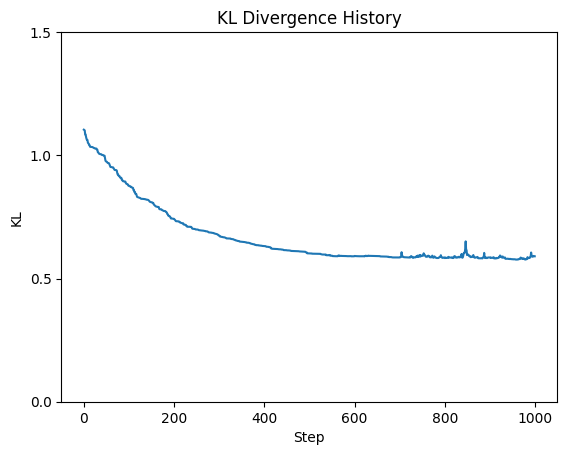

In [4]:
plt.plot(flow.kl_history)
plt.title('KL Divergence History')
plt.xlabel('Step')
plt.ylabel('KL')
plt.yticks([0, 0.5, 1.0, 1.5])

In [6]:
# # Test Case 1
# # This creates a crescent-shaped distribution, similar to the paper
# m = 1000
# x1 = np.random.randn(m)
# x2 = x1**2 + np.random.randn(m)
# x = np.zeros((m,2))
# x[:, 0] = x1
# x[:, 1] = x2
# print(x)
#
# # Train the model
# # Using parameters similar to the paper.
# # n_p = 50
# # n_steps = 500.
# model = NormalizingFlow(n_p=50, epsilon=0.5)
# model.fit(x, n_steps=600)

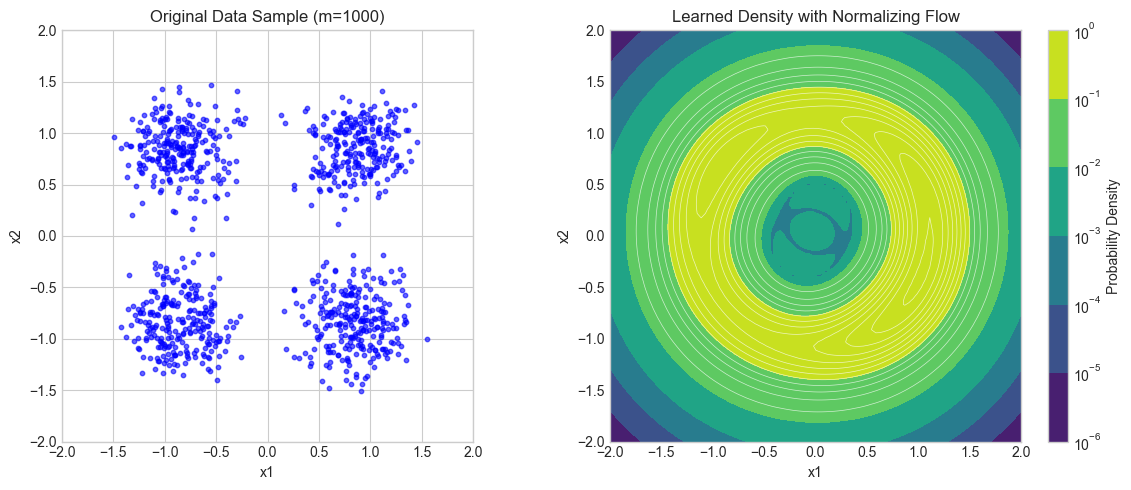

In [7]:


# Results
# Create a grid of points to evaluate the learned density
grid_res = 100
x_range = np.linspace(-2, 2, grid_res)
y_range = np.linspace(-2, 2, grid_res)
xx, yy = np.meshgrid(x_range, y_range)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Calculate the probability on the grid
log_p = flow.log_prob(grid_points)
p = np.exp(log_p).reshape(grid_res, grid_res)



# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(12, 5))

# Plot 1: Original Data
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(x[:, 0], x[:, 1], s=10, alpha=0.6, c='blue')
ax1.set_title("Original Data Sample (m=1000)")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)

# Plot 2: Learned Density
ax2 = fig.add_subplot(1, 2, 2)
# Use LogNorm for better visualization of low-density areas
contour = ax2.contourf(xx, yy, p, levels=15, cmap='viridis', norm=LogNorm())
ax2.contour(xx, yy, p, levels=15, colors='white', linewidths=0.5, alpha=0.7)
fig.colorbar(contour, ax=ax2, label="Probability Density")
ax2.set_title("Learned Density with Normalizing Flow")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)

plt.tight_layout()
plt.show()

In [433]:
def f_erf(r, alpha):
    """
    (Used above)
    
    f(r) = erf(r/α) / r
    """
    # Create an output array of the same shape and type as r
    f_vals = np.zeros_like(r, dtype=float)
    
    # Identify non-zero elements to avoid division by zero
    nonzero_r = r != 0
    
    # Calculate for non-zero r
    r_nz = r[nonzero_r]
    r_scaled = r_nz / alpha
    f_vals[nonzero_r] = erf(r_scaled) / r_nz
    
    # For r=0, use the limit: lim_{x->0} erf(x)/x = 2/sqrt(pi)
    f_vals[~nonzero_r] = 2.0 / (alpha * np.sqrt(np.pi))
    
    return f_vals

def F_erf_related(r, alpha):
    """
    Implements the function F(r) from the image.

    F(r) = r * erf(r/α) + (α/√π) * exp(-(r/α)²)
    """
    r_scaled = r / alpha
    term1 = r * erf(r_scaled)
    term2 = (alpha / np.sqrt(np.pi)) * np.exp(-r_scaled**2)
    return term1 + term2

# --- Other Radial Functions ---

def f_algebraic(r, alpha):
    """
    f(r) = 1 / (α + r)
    """
    return 1.0 / (alpha + r)

def f_compact_support(r, alpha):
    """
    f(r) = (1/α) * (1 - r/α)² for r < α, and 0 otherwise.
    """
    # Use np.where to apply the condition efficiently on arrays
    vals = (1.0 / alpha) * (1.0 - r / alpha)**2
    return np.where(r < alpha, vals, 0.0)

def f_exponential(r, alpha):
    """
    Implements a convex exponential decay radial function.
    
    f(r) = exp(-r/α)
    """
    return np.exp(-r / alpha)